<h1 style="text-align: center;">Project No. 1 - N-Grams & Sentiment Analysis</h1>

<h4 style="text-align: center;">

Esteban Gomez Valerio

Roi Jared Flores Garza Stone

Rafael Takata Garcia

Text Mining - O2025_MAF3654H

Ing. Juan Antonio Vega Fernández, M. Sc., M. T. Ed

ITESO
</h4>

#### Assignment Goals

- Understand and implement n-gram models (unigram, bigram, trigram).
- Apply these models to text classification for sentiment analysis.
- Perform basic feature extraction and preprocessing.
- Evaluate model performance using appropriate metrics.
- Conduct error analysis to identify strengths and limitations of n-gram models.

#### Libraries

In [1]:
import pandas as pd
import nltk
from datasets import load_dataset

c:\ITESOO\Mineria_textos\Sentiment_Analysis_with_ngrams\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Dataset

In this case, we charge the data directly from Hugging Face using the load_dataset function

In [2]:
imdb_data = load_dataset("imdb")

In [3]:
train = pd.DataFrame(imdb_data['train'])
test = pd.DataFrame(imdb_data['test'])
dev_data = pd.DataFrame(imdb_data['unsupervised'])
train.shape, test.shape, dev_data.shape

((25000, 2), (25000, 2), (50000, 2))

#### Data preprocessing



**Tokenize**

In [4]:
# Libraries
from nltk.tokenize import word_tokenize

In [5]:
### Run once to download the punkt tokenizer

# nltk.download("punkt")

In [6]:
# Function for tokenizing a batch of text

def nltk_tokenizer_batch(batch):
    return {"tokens": [word_tokenize(text) for text in batch["text"]]}

In [7]:
# Tokenizing the dataset
tokenized_imdb = imdb_data.map(nltk_tokenizer_batch, batched=True)

# Results
print("\n--- Tokenización Completada ---")
print(tokenized_imdb)



--- Tokenización Completada ---
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tokens'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'tokens'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'tokens'],
        num_rows: 50000
    })
})


In [8]:
print("\nTrain tokens:")
print(tokenized_imdb["train"][0]["tokens"][:20])


Train tokens:
['I', 'rented', 'I', 'AM', 'CURIOUS-YELLOW', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was']


In [9]:
print("\nTest tokens:")
print(tokenized_imdb["test"][0]["tokens"][:20])


Test tokens:
['I', 'love', 'sci-fi', 'and', 'am', 'willing', 'to', 'put', 'up', 'with', 'a', 'lot', '.', 'Sci-fi', 'movies/TV', 'are', 'usually', 'underfunded', ',', 'under-appreciated']


**Lowercasing and punctuation removal**

In [10]:
# Libraries
import re
import string
from nltk.corpus import stopwords

In [11]:
### Run once to download the stopwords

# nltk.download("stopwords")

In [12]:
# English stop words
stop_words = set(stopwords.words("english"))

In [13]:
def clean_tokens(batch):
    cleaned = []
    for tokens in batch["tokens"]:
        clean_list = []
        for token in tokens:
            token = token.lower()
            token = re.sub(f"[{re.escape(string.punctuation)}]", "", token)
            if token == "" or token in stop_words:
                continue
            clean_list.append(token)
        cleaned.append(clean_list)
    return {"clean_tokens": cleaned}

In [15]:
# Apply cleaning function
cleaned_imdb = tokenized_imdb.map(clean_tokens, batched=True)

Map: 100%|██████████| 50000/50000 [01:27<00:00, 573.38 examples/s]


In [16]:
# Remove 'tokens' column, replace with 'clean_tokens'
cleaned_imdb = cleaned_imdb.remove_columns("tokens")

In [17]:
# Results
print("\n--- Tokenización + Preprocesamiento Completado ---")
print(cleaned_imdb)

# Ejemplo: muestra los primeros 20 tokens limpios del primer registro
print(cleaned_imdb["train"][0]["clean_tokens"][:20])


--- Tokenización + Preprocesamiento Completado ---
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'clean_tokens'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'clean_tokens'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'clean_tokens'],
        num_rows: 50000
    })
})
['rented', 'curiousyellow', 'video', 'store', 'controversy', 'surrounded', 'first', 'released', '1967', 'also', 'heard', 'first', 'seized', 'us', 'customs', 'ever', 'tried', 'enter', 'country', 'therefore']


#### Feature Extraction

In [18]:
# Libraries
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Merge tokens back to text

def tokens_to_text(batch):
    return {"clean_text": [" ".join(tokens) for tokens in batch["clean_tokens"]]}

In [22]:
cleaned_imdb = cleaned_imdb.map(tokens_to_text, batched=True)

Map: 100%|██████████| 50000/50000 [00:12<00:00, 4092.73 examples/s]


In [ ]:
# Initialize CountVectorizer with n-grams (1, 3)
vectorizer = CountVectorizer(ngram_range=(1,3))  # unigramas, bigramas, trigramas

In [24]:
X_train = vectorizer.fit_transform(cleaned_imdb["train"]["clean_text"])
X_test = vectorizer.transform(cleaned_imdb["test"]["clean_text"])
X_unsup = vectorizer.transform(cleaned_imdb["unsupervised"]["clean_text"])

In [ ]:

print("Tamaño vocabulario:", len(vectorizer.vocabulary_))
print("Shape train:", X_train.shape)
print("Shape test:", X_test.shape)
print("Shape unsupervised:", X_unsup.shape)

Tamaño vocabulario: 4683153
Shape train: (25000, 4683153)
Shape test: (25000, 4683153)
Shape unsupervised: (50000, 4683153)


#### Model Training

In [26]:
# Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [ ]:
X_train_texts = cleaned_imdb["train"]["clean_text"]
y_train = cleaned_imdb["train"]["label"]  # 0 = negative, 1 = positive

X_val_texts = cleaned_imdb["test"]["clean_text"]
y_val = cleaned_imdb["test"]["label"]

In [ ]:
# Logistic Regression, Naive Bayes and SVM
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

# Ngrams to try
ngram_ranges = {
    "Unigram": (1,1),
    "Unigram+Bigram": (1,2),
    "Unigram+Bigram+Trigram": (1,3)
}


=== N-grams: Unigram ===
Logistic Regression: 0.8685
Naive Bayes: 0.8280


c:\ITESOO\Mineria_textos\Sentiment_Analysis_with_ngrams\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM: 0.8472

=== N-grams: Unigram+Bigram ===
Logistic Regression: 0.8896
Naive Bayes: 0.8540


c:\ITESOO\Mineria_textos\Sentiment_Analysis_with_ngrams\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM: 0.8854

=== N-grams: Unigram+Bigram+Trigram ===
Logistic Regression: 0.8892
Naive Bayes: 0.8599


c:\ITESOO\Mineria_textos\Sentiment_Analysis_with_ngrams\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM: 0.8876


#### Evaluation

In [ ]:
# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


=== Confusion Matrices - N-grams: Unigram ===


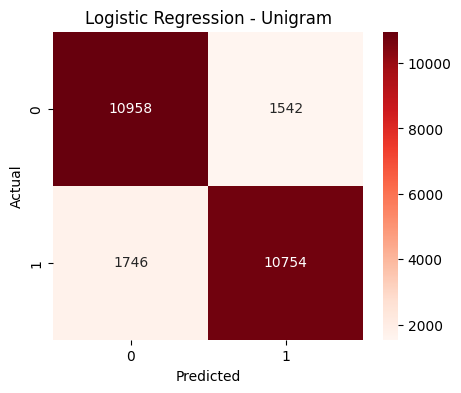

Logistic Regression Metrics (Unigram):
Accuracy : 0.8685
Precision: 0.8746
Recall   : 0.8603
F1-score : 0.8674



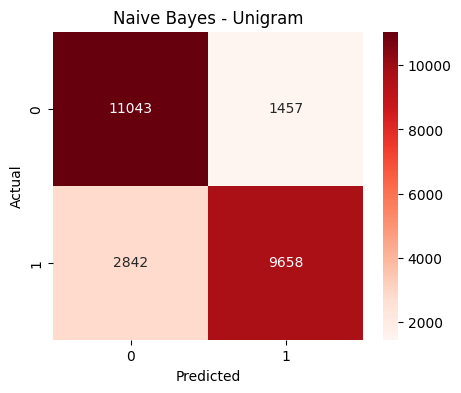

Naive Bayes Metrics (Unigram):
Accuracy : 0.8280
Precision: 0.8689
Recall   : 0.7726
F1-score : 0.8180



c:\ITESOO\Mineria_textos\Sentiment_Analysis_with_ngrams\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


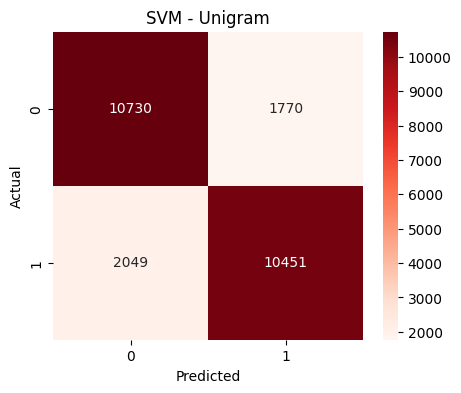

SVM Metrics (Unigram):
Accuracy : 0.8472
Precision: 0.8552
Recall   : 0.8361
F1-score : 0.8455


=== Confusion Matrices - N-grams: Unigram+Bigram ===


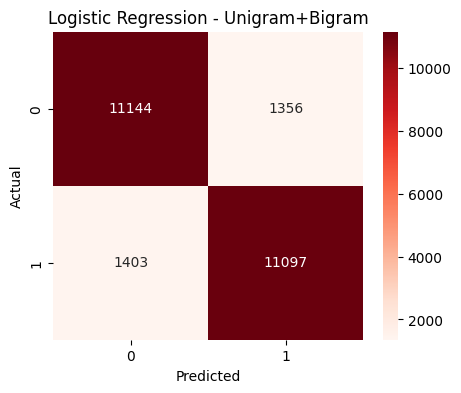

Logistic Regression Metrics (Unigram+Bigram):
Accuracy : 0.8896
Precision: 0.8911
Recall   : 0.8878
F1-score : 0.8894



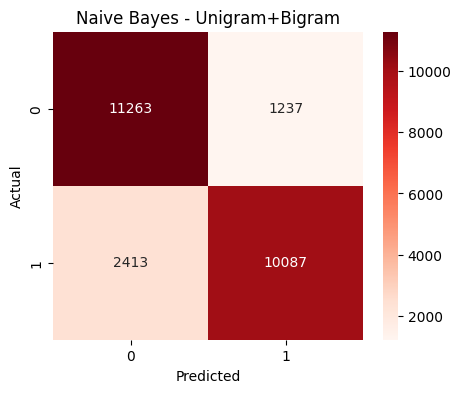

Naive Bayes Metrics (Unigram+Bigram):
Accuracy : 0.8540
Precision: 0.8908
Recall   : 0.8070
F1-score : 0.8468



c:\ITESOO\Mineria_textos\Sentiment_Analysis_with_ngrams\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


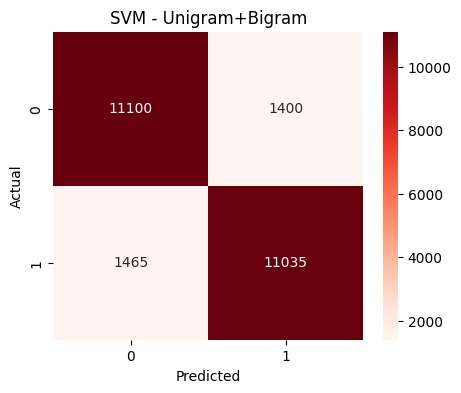

SVM Metrics (Unigram+Bigram):
Accuracy : 0.8854
Precision: 0.8874
Recall   : 0.8828
F1-score : 0.8851


=== Confusion Matrices - N-grams: Unigram+Bigram+Trigram ===


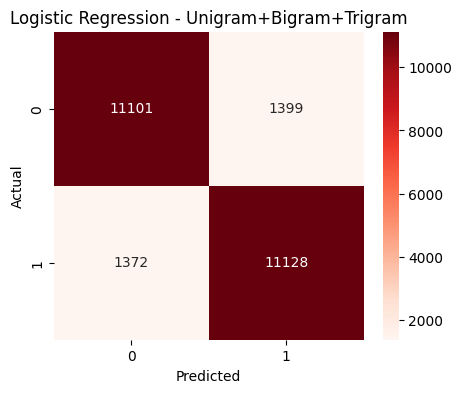

Logistic Regression Metrics (Unigram+Bigram+Trigram):
Accuracy : 0.8892
Precision: 0.8883
Recall   : 0.8902
F1-score : 0.8893



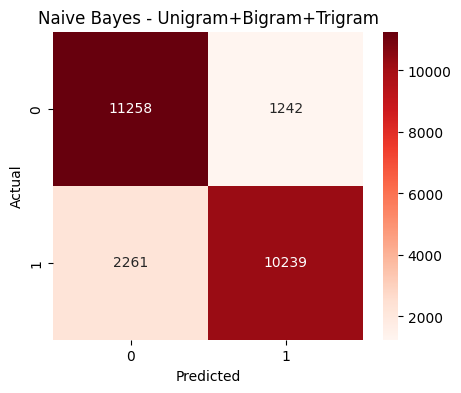

Naive Bayes Metrics (Unigram+Bigram+Trigram):
Accuracy : 0.8599
Precision: 0.8918
Recall   : 0.8191
F1-score : 0.8539



c:\ITESOO\Mineria_textos\Sentiment_Analysis_with_ngrams\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


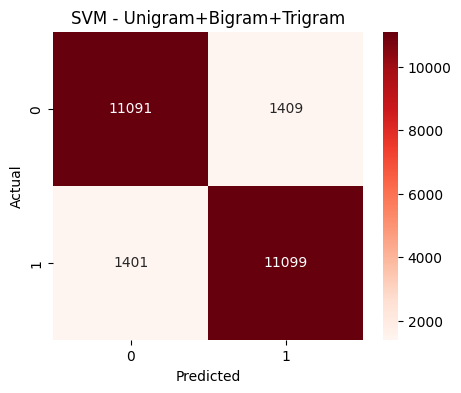

SVM Metrics (Unigram+Bigram+Trigram):
Accuracy : 0.8876
Precision: 0.8874
Recall   : 0.8879
F1-score : 0.8876



In [ ]:
for ngram_name, ngram_range in ngram_ranges.items():
    print(f"\n=== Confusion Matrices - N-grams: {ngram_name} ===")
    
    # Vectorización según el rango de n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_train = vectorizer.fit_transform(X_train_texts)
    X_val = vectorizer.transform(X_val_texts)
    
    for model_name, model in models.items():
        # Entrenamiento
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # Matriz de confusión
        cm = confusion_matrix(y_val, y_pred)
        
        plt.figure(figsize=(10,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1], yticklabels=[0,1])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{model_name} - {ngram_name}")
        plt.show()
        
        # Métricas de evaluación
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        print(f"{model_name} Metrics ({ngram_name}):")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}\n")